In [ ]:
!pip install transformers --quiet

In [ ]:
import os
import sys
import torch
import pickle
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Load raw tokenized text
with open('/ocean/projects/mth240012p/shared/data/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

# Example: view a random story
example_story = list(raw_text.keys())[0]
print("Story name:", example_story)
print("Tokens:", raw_text[example_story].data[:10])


Story name: sweetaspie
Tokens: ['', 'i', 'embarked', 'on', 'a', 'journey', 'toward', 'the', 'sea', 'of']


In [ ]:
# Load Frozen BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()
model.to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Extract Token-level Embeddings from the Last 4 Layers
def get_bert_embeddings(tokens):
    # Clean input: remove empty or whitespace-only tokens
    tokens = [t for t in tokens if t.strip()]

    if not tokens:
        raise ValueError("Token list became empty after cleaning")

    # Tokenize with special handling
    inputs = tokenizer(tokens, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)

    if inputs["input_ids"].shape[1] == 0:
        raise ValueError("Tokenizer returned empty input_ids")

    with torch.no_grad():
        outputs = model(**inputs.to(device))
        hidden_states = outputs.hidden_states[-1]  # last layer

    return hidden_states.mean(dim=1).cpu().numpy()



In [ ]:
successes = []
failures = []

save_dir = "bert_embeddings_frozen"
os.makedirs(save_dir, exist_ok=True)

for story_name, ds in tqdm(raw_text.items()):
    try:
        tokens = ds.data
        if not tokens or len(tokens) == 0:
            raise ValueError("No tokens to embed")

        emb = get_bert_embeddings(tokens)
        save_path = os.path.join(save_dir, f"{story_name}.npy")
        np.save(save_path, emb)
        successes.append(story_name)

    except Exception as e:
        print(f"Failed {story_name}: {e}")
        failures.append((story_name, str(e)))

print(f"\nSuccessful embeddings: {len(successes)}")
print(f"Failed embeddings: {len(failures)}")


100%|██████████| 109/109 [00:20<00:00,  5.23it/s]


Successful embeddings: 109
Failed embeddings: 0


In [ ]:
# Downsample and Delay BERT Embeddings for TR Alignment

import pickle
import numpy as np
from preprocessing import lanczosinterp2D, make_delayed

# Load raw_text again if not already available
if "raw_text" not in locals():
    with open('/ocean/projects/mth240012p/shared/data/raw_text.pkl', 'rb') as f:
        raw_text = pickle.load(f)

# Load the frozen BERT embeddings
embedding_dir = "bert_embeddings_frozen"
story_names = list(raw_text.keys())

# Build lookup dictionary
vectors = {s: np.load(f"{embedding_dir}/{s}.npy") for s in story_names}

# Step 1: Downsample to match fMRI TR times
def downsample_embeddings(story_list, vectors, wordseqs):
    downsampled = {}
    for story in story_list:
        vec = vectors[story]
        # Sanity check for alignment
        if len(wordseqs[story].data_times) != vec.shape[0]:
            story_duration = wordseqs[story].tr_times[-1]
            wordseqs[story].data_times = np.linspace(0, story_duration, vec.shape[0])

        downsampled[story] = lanczosinterp2D(
            vec,
            wordseqs[story].data_times,
            wordseqs[story].tr_times,
            window=3
        )
    return downsampled

# Apply downsampling
downsampled_embeddings = downsample_embeddings(story_names, vectors, raw_text)

# Step 2: Delay TRs
delays = [1, 2, 3, 4]
trim_front, trim_back = 5, 10

def trim_and_delay(data_dict):
    return {k: make_delayed(v[trim_front:-trim_back], delays) for k, v in data_dict.items()}

delayed_embeddings = trim_and_delay(downsampled_embeddings)



Evaluating subject2 with all voxels...
Shapes — X_train: (28298, 3072), Y_train: (28298, 94251)
Running bootstrap_ridge... (RAM: 8.2%)


/jet/home/jsu4/lab3/ridge_utils/ridge.py:8: RuntimeWarning: invalid value encountered in divide
  zs = lambda v: (v-v.mean(0))/v.std(0) ## z-score function
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]



Results for subject2 — BERT Embeddings:
Mean CC:   0.0176
Median CC: 0.0146
Top 1% CC: 0.0937
Top 5% CC: 0.0586


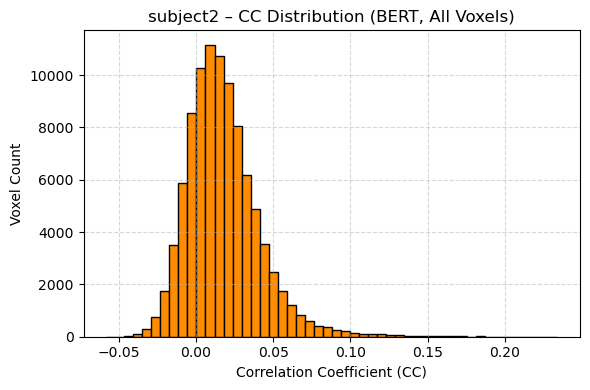

RAM after cleanup: 3.5%

Evaluating subject3 with all voxels...
Shapes — X_train: (28298, 3072), Y_train: (28298, 95556)
Running bootstrap_ridge... (RAM: 9.0%)

Results for subject3 — BERT Embeddings:
Mean CC:   0.0213
Median CC: 0.0183
Top 1% CC: 0.1134
Top 5% CC: 0.0652


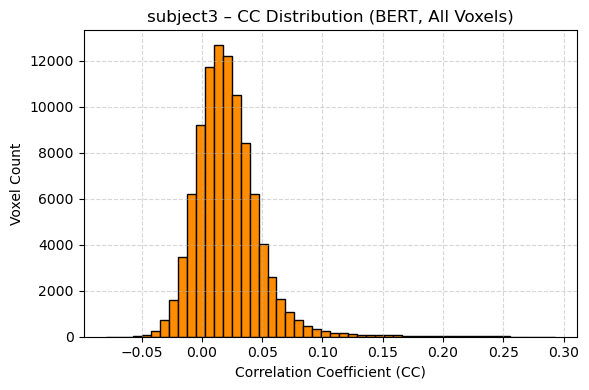

RAM after cleanup: 3.5%


In [ ]:
# Ridge Regression to Predict fMRI Voxels from BERT Embeddings

import os
import numpy as np
import matplotlib.pyplot as plt
import gc
import psutil
from ridge_utils.ridge import bootstrap_ridge, zs

subject_dirs = {
    "subject2": "/ocean/projects/mth240012p/shared/data/subject2",
    "subject3": "/ocean/projects/mth240012p/shared/data/subject3"
}

alphas = np.logspace(0, 3, 5)
nboots, chunklen, nchunks = 15, 10, 10

for subject, path in subject_dirs.items():
    print(f"\nEvaluating {subject} with all voxels...")

    # Step 1: Split delayed data into train/test by story
    story_names = list(delayed_embeddings.keys())
    n_train = int(len(story_names) * 0.8)
    train_keys = story_names[:n_train]
    test_keys = story_names[n_train:]

    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for sname in train_keys:
        y_path = os.path.join(path, f"{sname}.npy")
        if os.path.exists(y_path):
            X = delayed_embeddings[sname]
            Y = np.load(y_path, mmap_mode="r")
            if X.shape[0] == Y.shape[0]:
                X_train.append(X)
                Y_train.append(Y[:])

    for sname in test_keys:
        y_path = os.path.join(path, f"{sname}.npy")
        if os.path.exists(y_path):
            X = delayed_embeddings[sname]
            Y = np.load(y_path, mmap_mode="r")
            if X.shape[0] == Y.shape[0]:
                X_test.append(X)
                Y_test.append(Y[:])

    if not X_train or not X_test:
        print(f"Skipping {subject} — no valid aligned data.")
        continue

    # Step 2: Stack into arrays
    X_train = np.concatenate(X_train, axis=0).astype(np.float32)
    Y_train = np.concatenate(Y_train, axis=0).astype(np.float32)
    X_test = np.concatenate(X_test, axis=0).astype(np.float32)
    Y_test = np.concatenate(Y_test, axis=0).astype(np.float32)

    print(f"Shapes — X_train: {X_train.shape}, Y_train: {Y_train.shape}")

    # Step 3: Z-score
    X_mean, X_std = X_train.mean(0), X_train.std(0)
    Y_mean, Y_std = Y_train.mean(0), Y_train.std(0)

    X_train_z = (X_train - X_mean) / X_std
    Y_train_z = (Y_train - Y_mean) / Y_std
    X_test_z = (X_test - X_mean) / X_std
    Y_test_z = (Y_test - Y_mean) / Y_std

    del X_train, Y_train, X_test, Y_test
    gc.collect()

    print(f"Running bootstrap_ridge... (RAM: {psutil.virtual_memory().percent:.1f}%)")

    # Step 4: Fit ridge model
    wt, corrs, valphas, *_ = bootstrap_ridge(
        X_train_z, Y_train_z, X_test_z, Y_test_z,
        alphas=alphas,
        nboots=nboots,
        chunklen=chunklen,
        nchunks=nchunks,
        single_alpha=False,
        use_corr=True
    )

    np.save(f"valphas_{subject}_bert.npy", valphas)

    # Step 5: Report and plot
    print(f"\nResults for {subject} — BERT Embeddings:")
    print(f"Mean CC:   {np.mean(corrs):.4f}")
    print(f"Median CC: {np.median(corrs):.4f}")
    print(f"Top 1% CC: {np.percentile(corrs, 99):.4f}")
    print(f"Top 5% CC: {np.percentile(corrs, 95):.4f}")

    plt.figure(figsize=(6, 4))
    plt.hist(corrs, bins=50, color="darkorange", edgecolor="black")
    plt.title(f"{subject} – CC Distribution (BERT, All Voxels)")
    plt.xlabel("Correlation Coefficient (CC)")
    plt.ylabel("Voxel Count")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Step 6: Clean up
    del X_train_z, Y_train_z, X_test_z, Y_test_z
    del wt, corrs, valphas
    gc.collect()
    print(f"RAM after cleanup: {psutil.virtual_memory().percent:.1f}%")
